In [1]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Loading and Preparing the Data

In [124]:
# specify directory containing the csv files
directory = "EyeT/EyeT"

# create an empty list to store the loaded dataframes
dataframes = []

# loop through all files in the directory and load csv files with "dataset_III" in their name
for filename in os.listdir(directory):

    if "dataset_III" in filename and filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        # Columns to check duplicates
        columns_to_check = ['Participant name', 'Eye movement type', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right']

        # Replace , with . only for object type columns
        obj_cols = df.select_dtypes(include=['object']).columns

        # Loop over the columns and try to convert to numeric data type
        for col in obj_cols:
            try:
                df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
            except ValueError:
                # If the conversion fails, do nothing
                pass
            if df[col].apply(lambda x: str(x).isnumeric()).all():
                df[col] = pd.to_numeric(df[col], errors='coerce')
        # Drop exact duplicate rows based on specified columns
        df.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)

        # Reset index
        df.reset_index(drop=True, inplace=True)
        df = df.drop(columns=['Unnamed: 0'])
        dataframes.append(df)

# concatenate all dataframes into one dataframe
all_data = pd.concat(dataframes, ignore_index=True)

# print the shape of the resulting dataframe
print("Shape of the loaded data:", all_data.shape)


D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (31,32,33,34,35,41,42,43,46,47,48,49,50,51,52,53,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (20,21,34,35,50,51,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
D:\anaconda\lib\site-packages\IPython\

Shape of the loaded data: (996057, 70)


Merging and using only **Dataset III** as it was specifically collected for the purpose of assessing empathy using eye tracking data on gaze typing experiment. Also, we are checking for duplicates on 'Participant name', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right' column and dropping duplicate rows and the column **'Unnamed: 0'** as it is unecessary. Furthermore, we are replacing the ',' with '.' to make the columns numerical. Also, changing the dataype of columns to **'float'** that are actually numbers or scalar type but the dataype is currently 'object'. We are doing this so we can use these for correlation and PCA etc and we won't loose meaningful information.

# Exploring the data

In [125]:
all_data.tail()

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
996052,74088816,774760024,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,649.0,Unclassified,50.0,756.0,NaN,NaN,NaN,NaN,NaN,NaN
996053,74113753,774784961,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,649.0,Unclassified,17.0,757.0,NaN,NaN,NaN,NaN,NaN,NaN
996054,74163743,774834951,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,649.0,Unclassified,8.0,759.0,NaN,NaN,NaN,NaN,NaN,NaN
996055,74188757,774859965,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,649.0,Saccade,33.0,912.0,NaN,NaN,NaN,NaN,NaN,NaN
996056,74205245,774876453,NaN,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(all_data.dtypes)

Recording timestamp                      int64
Computer timestamp                       int64
Sensor                                  object
Project name                            object
Export date                             object
Participant name                        object
Recording name                          object
Recording date                          object
Recording date UTC                      object
Recording start time                    object
Recording start time UTC                object
Recording duration                       int64
Timeline name                           object
Recording Fixation filter name          object
Recording software version              object
Recording resolution height              int64
Recording resolution width               int64
Recording monitor latency              float64
Eyetracker timestamp                   float64
Event                                   object
Event value                             object
Gaze point X 

Checking for data types after the data has been loaded, doing this to ensure no meaningful column is left with unexpected datatype.

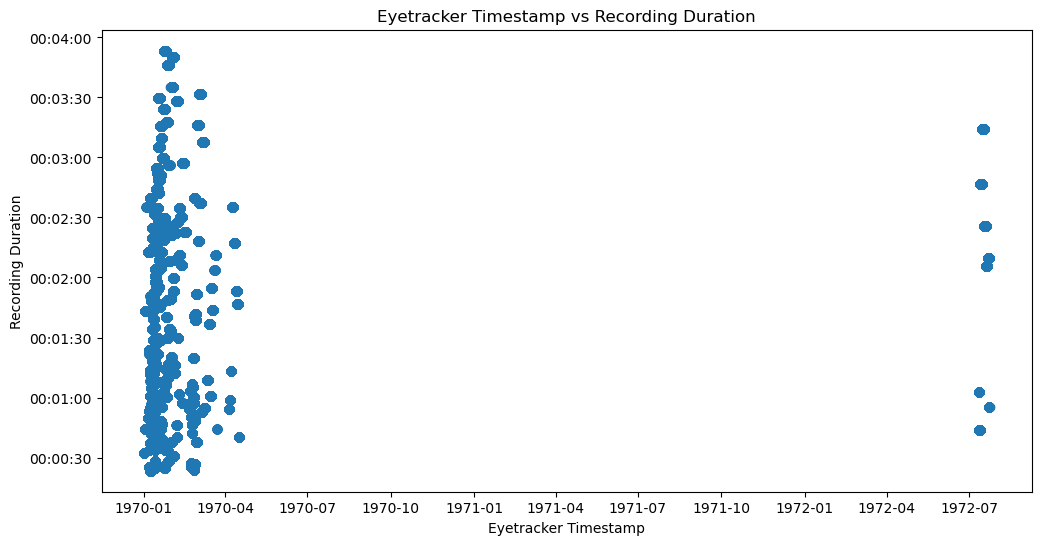

In [127]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a copy of the original dataset
all_data_copy = all_data.copy()

# Convert 'Eyetracker timestamp' column to datetime
all_data_copy['Eyetracker timestamp'] = pd.to_datetime(all_data_copy['Eyetracker timestamp'], unit='ms')

# Convert 'Recording duration' column to datetime in milliseconds
all_data_copy['Recording duration'] = pd.to_datetime(all_data_copy['Recording duration'], unit='ms')

# Set figure size
plt.figure(figsize=(12, 6)) # Width = 12 inches, Height = 6 inches

# Create scatter plot
plt.scatter(all_data_copy['Eyetracker timestamp'], all_data_copy['Recording duration'])

# Set plot labels and title
plt.xlabel('Eyetracker Timestamp')
plt.ylabel('Recording Duration')
plt.title('Eyetracker Timestamp vs Recording Duration')

# Show the plot
plt.show()


This plot shows the relationship between Eyetracker timestamp and Recording duration. We can observe that apart for some outliers, most of the data was actually collected at the very beggining of the time tracker timestamp. Or, we could say that time tracker device did not took time to initialize or stabilize before recording accurate data.

In [128]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')


In [129]:
# Load the QuestionnaireIB.csv file
questionnaire_ib = pd.read_csv('QuestionnaireIB.csv', encoding='ISO-8859-1')

# Merge the Empathy_Score column from questionnaire_ib into all_data based on Participant name
all_data = pd.merge(all_data, questionnaire_ib[['Participant name','Total Score extended']], on='Participant name', how='left')
all_data

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y,Total Score extended
0,23419315,512092386,NaN,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,...,Fixation,117.0,64.0,971.0,341.0,0.5073,0.316,NaN,NaN,137
1,23442782,512115853,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,...,Fixation,117.0,64.0,971.0,341.0,0.5073,0.316,NaN,NaN,137
2,23467779,512140850,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,...,Fixation,117.0,64.0,971.0,341.0,0.5073,0.316,NaN,NaN,137
3,23492835,512165906,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,...,Fixation,117.0,64.0,971.0,341.0,0.5073,0.316,NaN,NaN,137
4,23501167,512174238,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,...,Saccade,8.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996052,74088816,774760024,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,Unclassified,50.0,756.0,NaN,NaN,NaN,NaN,NaN,NaN,123
996053,74113753,774784961,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,Unclassified,17.0,757.0,NaN,NaN,NaN,NaN,NaN,NaN,123
996054,74163743,774834951,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,Unclassified,8.0,759.0,NaN,NaN,NaN,NaN,NaN,NaN,123
996055,74188757,774859965,Eye Tracker,Test group experiment,29.10.2020,Participant0003,Recording10,01.10.2020,01.10.2020,15:42:07.707,...,Saccade,33.0,912.0,NaN,NaN,NaN,NaN,NaN,NaN,123


Merging the **Total Score extended** of **Questionnaire IB**. We will be using the Total Score Extended as our output variable and we are using this as it includes the score of all the questions from the original questionnaire, plus additional questions.

array([[<AxesSubplot:title={'center':'Recording duration'}>,
        <AxesSubplot:title={'center':'Gaze point X'}>,
        <AxesSubplot:title={'center':'Gaze point Y'}>,
        <AxesSubplot:title={'center':'Gaze point left X'}>,
        <AxesSubplot:title={'center':'Gaze point left Y'}>],
       [<AxesSubplot:title={'center':'Gaze point right X'}>,
        <AxesSubplot:title={'center':'Gaze point right Y'}>,
        <AxesSubplot:title={'center':'Gaze direction left X'}>,
        <AxesSubplot:title={'center':'Gaze direction left Y'}>,
        <AxesSubplot:title={'center':'Gaze direction left Z'}>],
       [<AxesSubplot:title={'center':'Gaze direction right X'}>,
        <AxesSubplot:title={'center':'Gaze direction right Y'}>,
        <AxesSubplot:title={'center':'Gaze direction right Z'}>,
        <AxesSubplot:title={'center':'Pupil diameter left'}>,
        <AxesSubplot:title={'center':'Pupil diameter right'}>],
       [<AxesSubplot:title={'center':'Gaze event duration'}>,
        <A

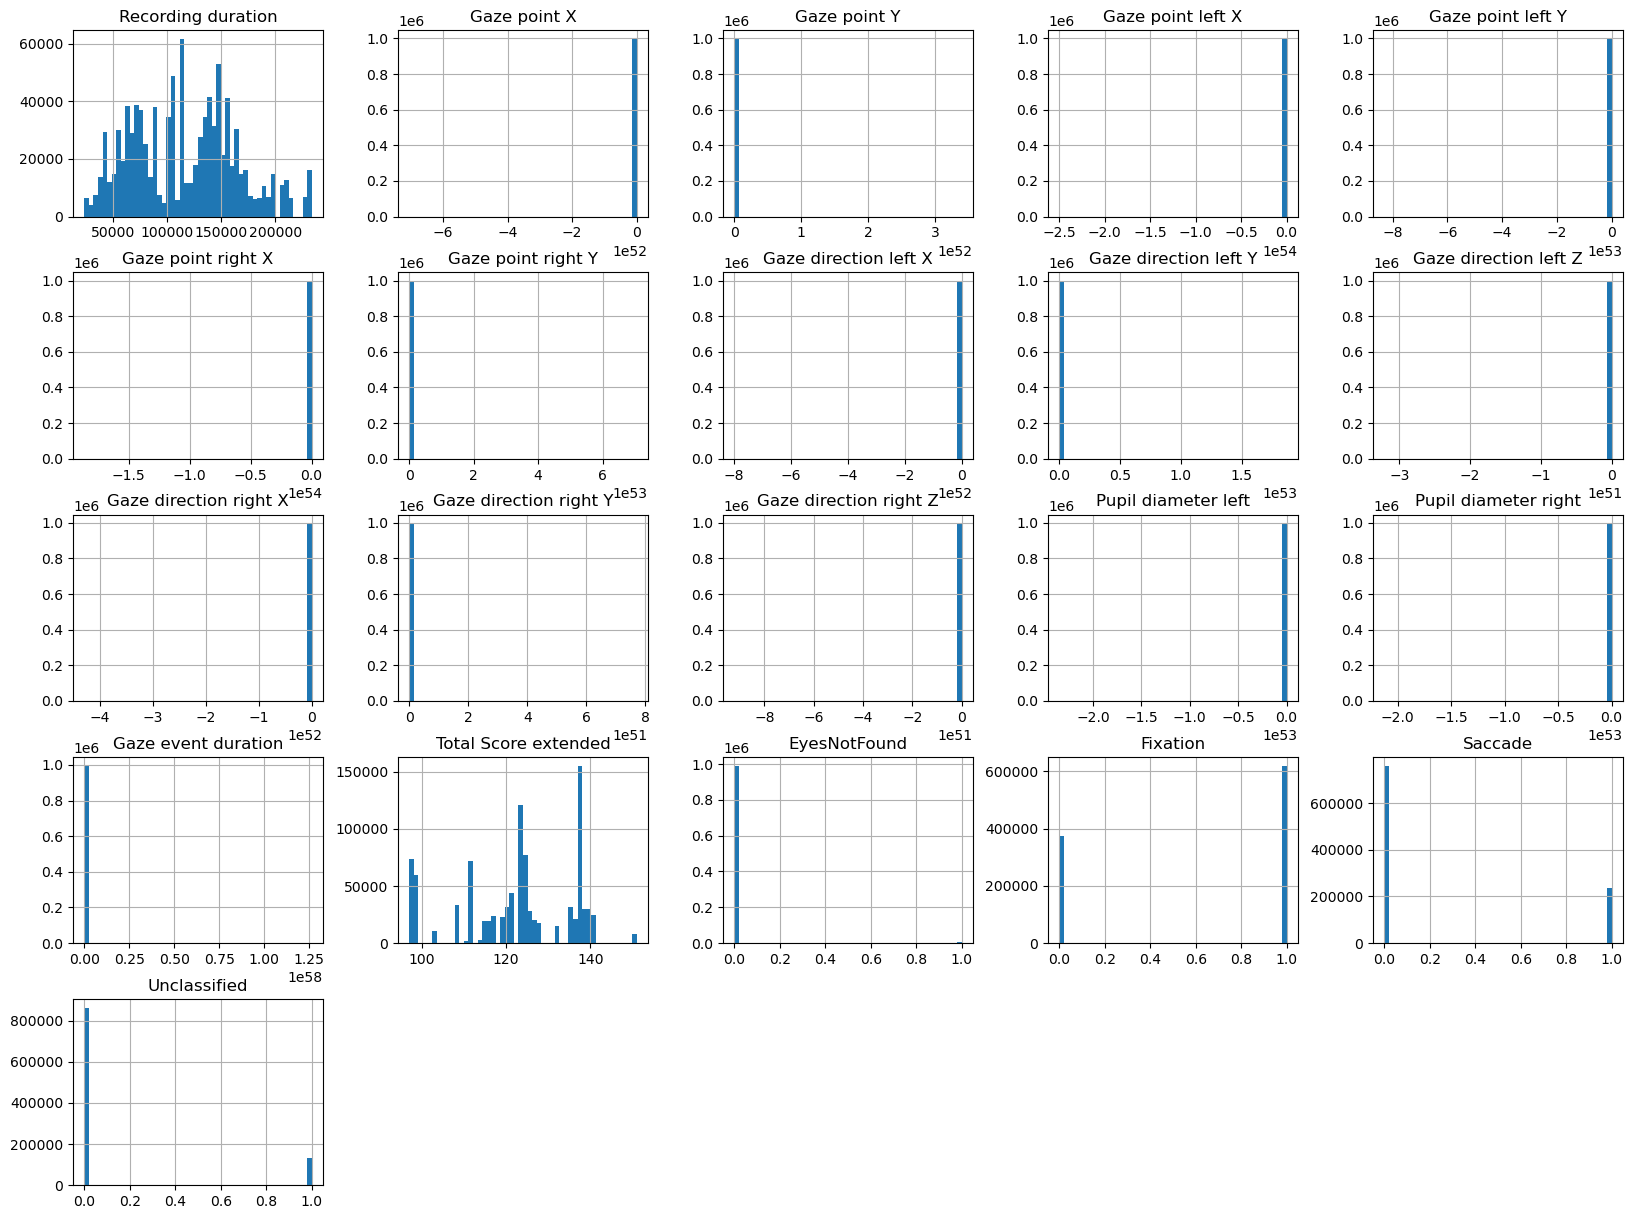

In [162]:
all_data.hist(bins=50, figsize=(20,15))

We can observe that mostly the data is skewed towards either side, only the recording duration is having kind of a symmetric distribution.

In [130]:
import pandas as pd

# Group by 'participant_name' and calculate the sum of 'recording_duration'
grouped = all_data.groupby('Participant name').agg({'Recording duration': 'sum'})

# Define a custom aggregation function to select the first value from an array
select_first = lambda x: x.iloc[0]

grouped['Gaze event duration'] = all_data.groupby('Participant name').agg({'Gaze event duration': 'sum'})

# Group by 'Participant name' and apply the custom aggregation function to 'Total Score Extended' column
grouped['Total Score Extended'] = all_data.groupby('Participant name')['Total Score extended'].agg(select_first)

# Reset the index to make 'Participant name' a regular column
grouped = grouped.reset_index()

# Drop duplicate rows of 'Participant name'
grouped = grouped.drop_duplicates(subset='Participant name', keep='first')

# Sort the DataFrame based on 'Total Score Extended' column in descending order
grouped = grouped.sort_values(by='Total Score Extended', ascending=False)

# Optional: Reset the index to have a consecutive integer index
grouped = grouped.reset_index(drop=True)

# 'grouped' DataFrame now contains unique rows with sum of recording_duration for each participant
grouped

,Participant name,Recording duration,Gaze event duration,Total Score Extended
0,Participant0011,841789475,1919777.0,151
1,Participant0023,2663492183,4281812.0,141
2,Participant0057,3617011616,7047144.0,140
3,Participant0035,3950112642,10599488.0,139
4,Participant0001,12423066402,21281448.0,137
5,Participant0015,2466125730,3845515.0,137
6,Participant0059,2705225327,3349086.0,136
7,Participant0029,4394380000,5071609.0,135
8,Participant0037,1483666233,2103776.0,132
9,Participant0041,2496315343,2909384.0,128


We have created a new df that has sum of Recording duration and	Gaze event duration for each participant as well as their extended score.

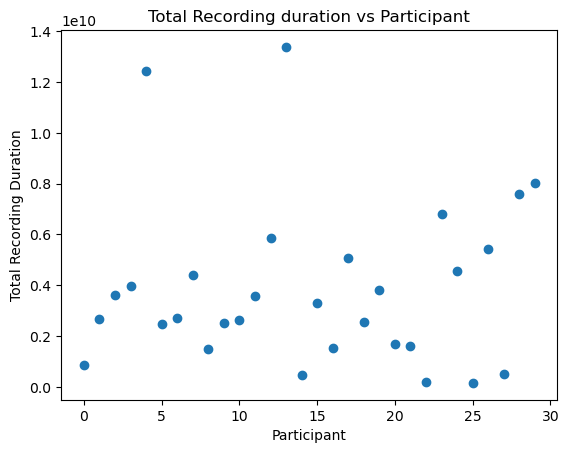

In [131]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped.index, grouped['Recording duration'])
plt.xlabel('Participant')
plt.ylabel('Total Recording Duration (miliseconds)')
plt.title('Total Recording duration vs Participant')
plt.show()


In this plot we can observe that majority of the participant took total duration of 0.8le^10 with 2 outliers as well.

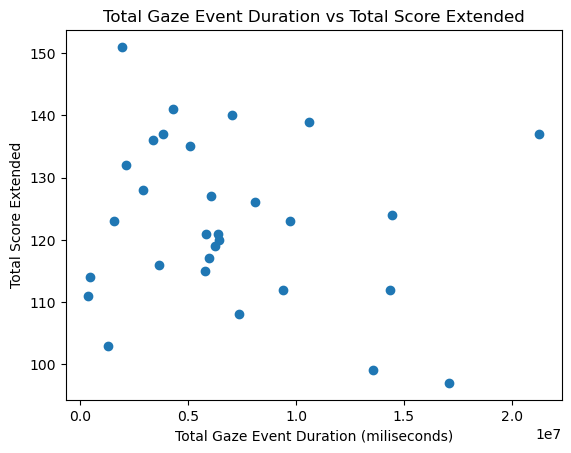

In [132]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped['Gaze event duration'], grouped['Total Score Extended'])
plt.xlabel('Total Gaze Event Duration (miliseconds)')
plt.ylabel('Total Score Extended')
plt.title('Total Gaze Event Duration vs Total Score Extended')
plt.show()

We can observe a ceiling effect on Total Gaze Event Duration vs Total Score Extended. the score is increasing as total gaze duraion is increasing and after duration reaches 0.5le^7 it started decreasing, this suggest that relationship between them is non linear.

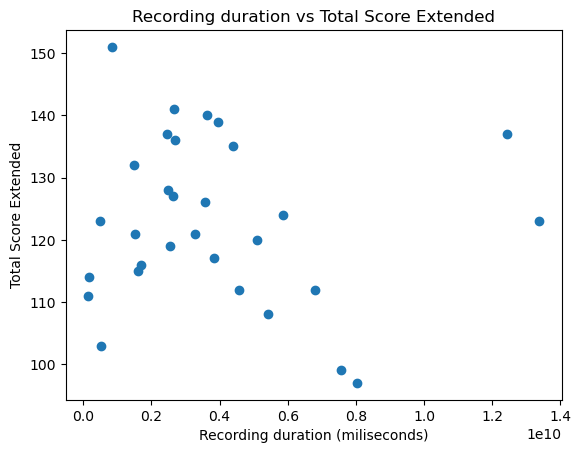

In [133]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped['Recording duration'], grouped['Total Score Extended'])
plt.xlabel('Recording duration (miliseconds)')
plt.ylabel('Total Score Extended')
plt.title('Recording duration vs Total Score Extended')
plt.show()


We can observe a ceiling effect on Total Recording duration vs Total Score Extended. The score is increasing as total recording duraion is increasing and after duration reaches 0.3le^10 it started decreasing, this suggest that relationship between them is non linear.

In [134]:
print("nulls:",all_data.isnull().sum())

nulls: Recording timestamp                0
Computer timestamp                 0
Sensor                           679
Project name                       0
Export date                        0
                               ...  
Fixation point X (MCSnorm)    435916
Fixation point Y (MCSnorm)    435916
Mouse position X              995389
Mouse position Y              995389
Total Score extended               0
Length: 71, dtype: int64


In [135]:
# perform one-hot encoding
one_hot = pd.get_dummies(all_data['Eye movement type'])

# concatenate the one-hot encoded columns to the original dataframe
all_data = pd.concat([all_data, one_hot], axis=1)

# drop the original categorical column
all_data.drop('Eye movement type', axis=1, inplace=True)

all_data_copy = all_data

Performing one hot encoding on **Eye movement type** because based it might have some important information and we need to perform correalation on these as well.

In [136]:
# Compute correlation matrix
corr_matrix = all_data.corr()

# Extract correlation coefficients for the score column
score_corr = corr_matrix['Total Score extended']
print(score_corr)

Recording timestamp                   -0.047239
Computer timestamp                     0.104456
Recording duration                    -0.110752
Recording resolution height                 NaN
Recording resolution width                  NaN
Recording monitor latency                   NaN
Eyetracker timestamp                   0.089850
Gaze point X                           0.011177
Gaze point Y                          -0.124067
Gaze point left X                     -0.039001
Gaze point left Y                     -0.135886
Gaze point right X                     0.062001
Gaze point right Y                    -0.127969
Gaze direction left X                 -0.025045
Gaze direction left Y                 -0.128231
Gaze direction left Z                 -0.056233
Gaze direction right X                 0.103267
Gaze direction right Y                -0.109578
Gaze direction right Z                -0.069792
Pupil diameter left                   -0.252200
Pupil diameter right                  -0

We can observe that corelation matrix is majorly negative and not showing any strong correlation of differnt columns with Total Score Extended.

In [137]:
numeric_cols = all_data.select_dtypes(include=['float64', 'int64','uint8']).columns.tolist()
df_numeric = all_data[numeric_cols].copy()
df_numeric = df_numeric.fillna(0)

Selecting all the numeric columns so we can normalize it by filling nans with 0 to perform regressor feature extraction and PCA to extract some features.

In [138]:
# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_scaled = scaler.fit_transform(df_numeric)

# Convert the scaled data back to a DataFrame
df_normalized = pd.DataFrame(df_scaled, columns=df_numeric.columns)


Normalizing the data so we have everything scaled within a range.

In [139]:
# Fit the decision tree regressor to the data
clf = DecisionTreeRegressor()
clf.fit(X, y)

# Calculate feature importances
importances = clf.feature_importances_
importances

array([ 9.48328434e-01,  5.26932520e-19,  0.00000000e+00,  9.94354235e-17,
        1.92010239e-18,  5.05090883e-02,  1.16247798e-03,  8.59924650e-15,
       -4.06035917e-18,  2.84043677e-18,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.61122022e-14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.62085676e-18,  4.96802525e-18,  6.03786347e-14,
        0.00000000e+00])

In [140]:
# Calculate feature importances
importances = clf.feature_importances_

# Convert the values to regular numbers
importances = np.round(importances * 100, decimals=2)

# Create a dictionary to map attribute names with importance values
importances_dict = {attr: imp for attr, imp in zip(X.columns, importances)}

# Print the dictionary
importances_dict

{'Recording duration': 94.83,
 'Pupil diameter left': 0.0,
 'Pupil diameter right': 0.0,
 'Gaze event duration': -0.0,
 'EyesNotFound': 0.0,
 'Fixation': 5.05,
 'Saccade': 0.12,
 'Unclassified': 0.0,
 'Gaze point X': 0.0,
 'Gaze point Y': 0.0,
 'Gaze point left X': 0.0,
 'Gaze point left Y': 0.0,
 'Gaze point right X': 0.0,
 'Gaze point right Y': 0.0,
 'Gaze direction left X': 0.0,
 'Gaze direction left Y': 0.0,
 'Gaze direction left Z': 0.0,
 'Gaze direction right X': 0.0,
 'Gaze direction right Y': 0.0,
 'Gaze direction right Z': 0.0}

Here we can see that majorly Recording Duration has most of the impact on the model with contribution of almost 95%

# PCA

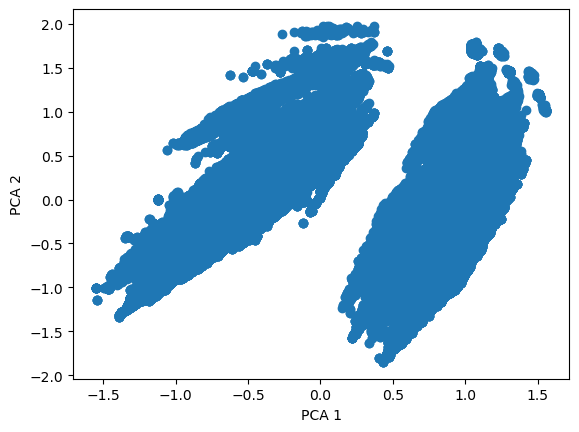

In [141]:
# One-hot encode categorical variables
data_encoded = df_normalized

# Separate target variable
y = data_encoded['Total Score extended']
X = data_encoded.drop(['Total Score extended'], axis=1)

# Perform PCA
pca = PCA()
pca.fit(df_scaled)

# Choose the number of components to keep
variance_ratio = pca.explained_variance_ratio_
n_components = len(variance_ratio[variance_ratio > 0.01])

# Transform the data to reduced dimension space
df_pca = pca.transform(df_scaled)[:, :n_components]

# Visualize the data
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [142]:
#Extract the most important features
components = pd.DataFrame(pca.components_)
most_important = components.abs().max(axis=0).sort_values(ascending=False)

# Create a dictionary to map feature indices to column names
feature_map = dict(zip(range(len(X.columns)), X.columns))

# Get the column names and loading scores of the top 10 most important features
top_features = [(feature_map[i], score) for i, score in enumerate(most_important[:-1])]

# Sort the top features by loading score in descending order
top_features = sorted(top_features, key=lambda x: x[1], reverse=True)

# Print the top 10 most important features with their corresponding column names and loading scores
for i, (feature, score) in enumerate(top_features):
    print(f"{i+1}. {feature}: {score:.3f}")


1. Recording timestamp: 1.000
2. Computer timestamp: 0.988
3. Recording duration: 0.969
4. Recording resolution height: 0.929
5. Recording resolution width: 0.874
6. Recording monitor latency: 0.865
7. Eyetracker timestamp: 0.813
8. Gaze point X: 0.792
9. Gaze point Y: 0.791
10. Gaze point left X: 0.791
11. Gaze point left Y: 0.779
12. Gaze point right X: 0.751
13. Gaze point right Y: 0.738
14. Gaze direction left X: 0.730
15. Gaze direction left Y: 0.707
16. Gaze direction left Z: 0.707
17. Gaze direction right X: 0.707
18. Gaze direction right Y: 0.707
19. Gaze direction right Z: 0.707
20. Pupil diameter left: 0.707
21. Pupil diameter right: 0.706
22. Eye position left X (DACSmm): 0.706
23. Eye position left Y (DACSmm): 0.706
24. Eye position left Z (DACSmm): 0.705
25. Eye position right X (DACSmm): 0.705
26. Eye position right Y (DACSmm): 0.699
27. Eye position right Z (DACSmm): 0.672
28. Gaze point left X (DACSmm): 0.659
29. Gaze point left Y (DACSmm): 0.642
30. Gaze point right X 

Here we have list of all the useful features and their contributions identofied by PCA. At this point we have regressor identified columns as well as PCA ones, now we will apply our domain knowledge to filter the useful features.

# Preparing the data

In [143]:
# Define the useful columns and dropping the rest
cols_to_keep = ['Recording duration', 'Pupil diameter left', 'Pupil diameter right', 'Gaze event duration', 'EyesNotFound','Fixation','Saccade','Unclassified','Gaze event duration', 'Gaze point X', 'Gaze point Y','Gaze point left X','Gaze point left Y','Gaze point right X','Gaze point right Y','Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z','Total Score extended']
all_data = all_data_copy.drop(columns=[col for col in all_data.columns if col not in cols_to_keep])

Here, we have idenfitifed and filtered out the useful features. The selection is based on their contribution as well as domain knowledge.

In [144]:
# Create an instance of IterativeImputer
imputer = IterativeImputer()

# Fit the imputer to the data
imputer.fit(all_data[cols_to_keep])

# Transform the data, replacing the missing values with the imputed values
all_data[cols_to_keep] = imputer.transform(all_data[cols_to_keep])

D:\anaconda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Now, we are imputing the data with iterative impute approach of scikit with **Baysian Ridge** method which is the defaut method. This will fill the null values more effieciently rather than filling with 0. Please note that it will fill the values within the range of the observed or currently available data so the data won't be out of the current range. Eg: if pupil diamter is in a range of 0-40, imputation will also be within this range.

In [145]:
all_data[cols_to_keep]

,Recording duration,Pupil diameter left,Pupil diameter right,Gaze event duration,EyesNotFound,Fixation,Saccade,Unclassified,Gaze event duration,Gaze point X,...,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,Gaze direction right X,Gaze direction right Y,Gaze direction right Z,Total Score extended
0,83579.0,3.020028e+00,3.062884e+00,1.170000e+02,0.0,1.0,0.0,0.0,1.170000e+02,9.131449e+02,...,4.613261e+02,9.774684e+02,4.511039e+02,2.106434e-02,8.777930e-02,-9.736478e-01,-2.486484e-02,8.646389e-02,-9.751732e-01,137.0
1,83579.0,3.210000e+00,3.140000e+00,1.170000e+02,0.0,1.0,0.0,0.0,1.170000e+02,9.620000e+02,...,2.920000e+02,1.012000e+03,4.000000e+02,6.370000e-02,3.550000e-03,-9.979600e-01,1.510000e-02,4.013000e-02,-9.990800e-01,137.0
2,83579.0,3.150000e+00,3.310000e+00,1.170000e+02,0.0,1.0,0.0,0.0,1.170000e+02,9.770000e+02,...,2.920000e+02,1.032000e+03,3.710000e+02,6.699000e-02,3.540000e-03,-9.977500e-01,2.165000e-02,3.108000e-02,-9.992800e-01,137.0
3,83579.0,3.130000e+00,3.190000e+00,1.170000e+02,0.0,1.0,0.0,0.0,1.170000e+02,9.750000e+02,...,4.290000e+02,1.023000e+03,2.530000e+02,6.847000e-02,4.871000e-02,-9.964600e-01,1.845000e-02,-7.110000e-03,-9.998000e-01,137.0
4,83579.0,2.948700e+00,2.993619e+00,8.000000e+00,0.0,0.0,1.0,0.0,8.000000e+00,9.890000e+02,...,3.230000e+02,1.028000e+03,2.520000e+02,7.627000e-02,1.394000e-02,-9.969900e-01,2.009000e-02,-7.560000e-03,-9.997700e-01,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996052,74360.0,3.060000e+00,3.290000e+00,5.000000e+01,0.0,0.0,0.0,1.0,5.000000e+01,1.038000e+03,...,7.250000e+02,1.196000e+03,7.120000e+02,4.179000e-02,9.397000e-02,-9.947000e-01,6.430000e-02,8.757000e-02,-9.940800e-01,123.0
996053,74360.0,3.350000e+00,3.180000e+00,1.700000e+01,0.0,0.0,0.0,1.0,1.700000e+01,1.072000e+03,...,7.220000e+02,1.229000e+03,6.390000e+02,5.224000e-02,9.325000e-02,-9.942700e-01,7.386000e-02,6.496000e-02,-9.951500e-01,123.0
996054,74360.0,3.290000e+00,3.050000e+00,8.000000e+00,0.0,0.0,0.0,1.0,8.000000e+00,1.090000e+03,...,7.160000e+02,1.259000e+03,6.450000e+02,5.238000e-02,9.203000e-02,-9.943800e-01,8.180000e-02,6.740000e-02,-9.943700e-01,123.0
996055,74360.0,3.300000e+00,3.220000e+00,3.300000e+01,0.0,0.0,1.0,0.0,3.300000e+01,1.065000e+03,...,8.330000e+02,1.211000e+03,7.390000e+02,5.054000e-02,1.284500e-01,-9.904300e-01,6.605000e-02,9.662000e-02,-9.931300e-01,123.0


In [146]:
# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_scaled = scaler.fit_transform(all_data[cols_to_keep])

# Convert the scaled data back to a DataFrame
df_normalized = pd.DataFrame(df_scaled, columns=all_data[cols_to_keep].columns)

# Training and Evaluating the Model

In [147]:
# assuming your DataFrame is called 'df_normalized' and the target variable is called 'y'
X = df_normalized.drop('Total Score extended', axis=1)
y = df_normalized['Total Score extended']

# split the data into 70% train and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# verify the shapes of the resulting arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (697239, 21)
Shape of y_train: (697239,)
Shape of X_test: (298818, 21)
Shape of y_test: (298818,)


Here, we have normalized and splitted the data into train test. We will be using this split for our model training.

In [148]:
from sklearn.model_selection import cross_val_score

# create an instance of the Random Forest Regressor class
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# perform 5-fold cross-validation on the model
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# compute the mean and standard deviation of the scores
mean_score = -scores.mean()
std_score = scores.std()

print("Mean Squared Error (MSE) on cross-validation: {:.3f} +/- {:.3f}".format(mean_score, std_score))


Mean Squared Error (MSE) on cross-validation: 0.046 +/- 0.026


Here, we have validated the randomforest regressor with 5 foldds. MSE is **0.046** which is very low and this suggest that the model is quite accurate. We also have standard deviation of MSE on cross-validated folds which is **0.026**, again low deviation suggest the model is quite stable.

In [149]:
# create an instance of the Random Forest Regressor class
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# fit the model to the training data
rf.fit(X_train, y_train)

# make predictions on the test data
y_pred = rf.predict(X_test)

# compute the mean squared error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE) on test set: {:.3f}".format(mse))


Mean Squared Error (MSE) on test set: 0.000


To our surprise we can see the model is giving the MSE of 0.000 which suggest the model's accuracy is 100%. Please note that we have already dropped the duplicates and filled the nans so this possibly is not the case of over fitting.

# Predicting

In [159]:
# Load the test data
test = pd.read_csv('EyeT/EyeT/EyeT_group_dataset_II_image_name_grey_blue_participant_2_trial_0.csv')

columns_to_check = ['Participant name', 'Eye movement type', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right']

test.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)

# Reset index
test.reset_index(drop=True, inplace=True)

# perform one-hot encoding
one_hot = pd.get_dummies(test['Eye movement type'])

# concatenate the one-hot encoded columns to the original dataframe
test = pd.concat([test, one_hot], axis=1)

# drop the original categorical column
test.drop('Eye movement type', axis=1, inplace=True)

test['Total Score extended'] = '0'

df = test

# Replace , with . only for object type columns
obj_cols = df.select_dtypes(include=['object']).columns

# Loop over the columns and try to convert to numeric data type
for col in obj_cols:
    try:
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    except ValueError:
        # If the conversion fails, do nothing
        pass
    if df[col].apply(lambda x: str(x).isnumeric()).all():
        df[col] = pd.to_numeric(df[col], errors='coerce')

cols_to_keep = ['Recording duration', 'Pupil diameter left', 'Pupil diameter right', 'Gaze event duration', 'EyesNotFound','Fixation','Saccade','Unclassified','Gaze event duration', 'Gaze point X', 'Gaze point Y','Gaze point left X','Gaze point left Y','Gaze point right X','Gaze point right Y','Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z','Total Score extended']

# Extract the columns of interest from the test data
test_data = df[cols_to_keep]

# Use the fitted imputer to transform the test data
imputed_test_data = imputer.transform(test_data)

# Replace the missing values in the test data with the imputed values
test_data = imputed_test_data

# Transform the test data using the previously fitted scaler object
test_data_scaled = scaler.transform(test_data)

test_data = pd.DataFrame(test_data_scaled)

# Convert the scaled test data back to a DataFrame
test_data_normalized = pd.DataFrame(test_data_scaled, columns=test_data.columns)
test_data_normalized = imputer.transform(test_data_normalized)

test_data_normalized = pd.DataFrame(test_data_normalized)
test_data_normalized.drop(21, axis=1, inplace=True)

# Predict
score = rf.predict(test_data_normalized)

test_data_normalized['score'] = score

# Use the trained scaler object to denormalize the predicted values
y_pred_denormalized = scaler.inverse_transform(test_data_normalized)

pred = pd.DataFrame(y_pred_denormalized)

# Get the Score and the features that contributed
score = pred[21][0]
print("Empathy Score",score)

# Calculate feature importances
importances = rf.feature_importances_

# Convert the values to regular numbers
importances = np.round(importances * 100, decimals=3)

# Create a dictionary to map attribute names with importance values
importances_dict = {attr: imp for attr, imp in zip(X.columns, importances)}

# Print the dictionary
print("\nThe Explaination for the Score: below we have a dictionary with contribution score where, 100% means mostly contributed:")
importances_dict

Empathy Score 141.00000000000009

The Explaination for the Score, below we have a dictionary with contribution score where, 100% means mostly contributed:


D:\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IterativeImputer was fitted with feature names
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


{'Recording duration': 99.983,
 'Pupil diameter left': 0.0,
 'Pupil diameter right': 0.0,
 'Gaze event duration': 0.0,
 'EyesNotFound': 0.0,
 'Fixation': 0.016,
 'Saccade': 0.0,
 'Unclassified': 0.0,
 'Gaze point X': 0.0,
 'Gaze point Y': 0.0,
 'Gaze point left X': 0.0,
 'Gaze point left Y': 0.0,
 'Gaze point right X': 0.0,
 'Gaze point right Y': 0.0,
 'Gaze direction left X': 0.0,
 'Gaze direction left Y': 0.0,
 'Gaze direction left Z': 0.0,
 'Gaze direction right X': 0.0,
 'Gaze direction right Y': 0.0,
 'Gaze direction right Z': 0.0}

The above cell is the final cell and is responsible to predict score. We just have to load onboarding potential employee's required data into test dataset and it will return the empathy score and the reason for the score with a key:value pair. Where, key is the feature and value will be its contribution towards the score.